# Project 3 - Catching the Bag: Forecasting the NFL Wide Receiver Contracts Based Upon Historical Statistics

In [1]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import requests
from bs4 import BeautifulSoup
from time import sleep
from great_tables import GT, system_fonts, style, loc, md
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

# Nulla. Getting our dataset

In [2]:
def organize_data(position_dict: dict) -> dict:
    """Organize a dictionary of raw HTML into a formatted data dictionary

    Args:
        position_dict (dict): Dictionary of scraped HTML, with keys as positions and values are a list of HTML

    Returns:
        dict: Formatted data
    """
    # Create the lists to hold our data
    player_names: list = []
    player_teams: list = []
    player_positions: list = []
    player_contract_sign_dates: list = []
    player_contract_len: list = []
    player_contract_values: list = []
    player_contract_APYs: list = []
    player_contract_guarantees: list = []
    player_active_contracts: list = []

    for pos, position_list in position_dict.items():
        for player in position_list[1::]: # The first row is always a header, so we ignore that
            player_text: list = [attr.text for attr in player.find_all('td')]
            player_names.append(player_text[0])
            player_teams.append(player_text[1].split('/')[-1]) # Get the last team they played for
            player_positions.append(pos)
            player_contract_sign_dates.append(int(player_text[2]))
            player_contract_len.append(player_text[3])
            player_contract_values.append(float(player_text[5].replace('$', '').replace(',',''))) # Clean up the dollar amount
            player_contract_APYs.append(float(player_text[6].replace('$', '').replace(',','')))
            player_contract_guarantees.append(float(player_text[7].replace('$', '').replace(',','')))
            player_active_contracts.append(1 if "active" in player.get("class", []) else 0)

    data: dict = {
    'Name': player_names,
    'Team': player_teams,
    'Position': player_positions,
    'Sign Date': player_contract_sign_dates,
    'Contract Length': player_contract_len,
    'Contract Value ($)': player_contract_values,
    'APY ($)': player_contract_APYs,
    'Guarantees ($)': player_contract_guarantees,
    'Active': player_active_contracts
    }

    return data

In [3]:
def get_contract_data(positions_list: list, contract_url: str = 'https://overthecap.com/contract-history/') -> pd.DataFrame:
    """Scrape, organize, and format our contract data; intended to be sourced from overthecap.com

    Args:
        positions_list (list): list of positions to scrape
        contract_url (str, optional): url to scrape from. Defaults to 'https://overthecap.com/contract-history/'.

    Returns:
        pd.DataFrame: dataframe of all players positions and contract information
    """
    # Get the raw HTML data from the contract_url
    position_contracts_raw: list[bytes] = [requests.get(f"{contract_url}{position.lower().replace(' ', '-')}").content for position in positions_list]

    # Parse the HTML to include only the body information
    position_contracts_parsed: list[BeautifulSoup] = [BeautifulSoup(contracts_page, 'html.parser') for contracts_page in position_contracts_raw]

    # Format the parsed HTML into a position dictionary, getting only the table rows in the process
    position_contracts_dict: dict = {pos:data for pos, data in zip(positions_list, [contract_content.find_all('tr') for contract_content in position_contracts_parsed])}

    # Organize our data into a dataframe dict
    data = organize_data(position_contracts_dict)

    return pd.DataFrame(data)


In [4]:
POSITIONS = ['Quarterback', 'Running Back', 'Wide Receiver', 'Edge Rusher', 'Linebacker', 'Safety', 'Cornerback']

POSITION_CONTRACT_URL: str = 'https://overthecap.com/contract-history/'

contract_df: pd.DataFrame = get_contract_data(POSITIONS, POSITION_CONTRACT_URL)

contract_df.head()

,Name,Team,Position,Sign Date,Contract Length,Contract Value ($),APY ($),Guarantees ($),Active
0,Joe Burrow,Bengals,Quarterback,2023,5,275000000.0,55000000.0,219010000.0,1
1,Aaron Rodgers,NYJ,Quarterback,2022,5,150815000.0,50271667.0,150665000.0,0
2,Josh Allen,Bills,Quarterback,2021,6,258000000.0,43000000.0,150000000.0,0
3,Russell Wilson,Broncos,Quarterback,2022,5,245000000.0,49000000.0,165000000.0,0
4,Dak Prescott,Cowboys,Quarterback,2024,4,240000000.0,60000000.0,231000000.0,1


In [5]:
contract_df.loc[contract_df['Position'] != 'Quarterback'].sort_values(by='APY ($)', ascending=False)

,Name,Team,Position,Sign Date,Contract Length,Contract Value ($),APY ($),Guarantees ($),Active
5307,Ja'Marr Chase,Bengals,Wide Receiver,2025,4,161000000.0,40250000.0,109800000.0,1
11942,Myles Garrett,Browns,Edge Rusher,2025,4,160000000.0,40000000.0,123596125.0,1
11947,Danielle Hunter,Texans,Edge Rusher,2025,2,55100000.0,35600000.0,54100000.0,1
11948,Maxx Crosby,Raiders,Edge Rusher,2025,3,106500000.0,35500000.0,91500000.0,1
5311,Justin Jefferson,Vikings,Wide Receiver,2024,4,140000000.0,35000000.0,110000000.0,1
...,...,...,...,...,...,...,...,...,...
11817,Tevin Reese,Bengals,Wide Receiver,2014,1,107100.0,0.0,0.0,0
11825,Kendrick Ings,Lions,Wide Receiver,0,,0.0,0.0,0.0,0
11826,Brandon Stokley,Broncos,Wide Receiver,2007,1,1500000.0,0.0,0.0,0
11829,Josh Reynolds,Jets,Wide Receiver,2025,1,0.0,0.0,0.0,1


In [6]:
df = contract_df.loc[(contract_df['Position'] == 'Wide Receiver') & (contract_df['Sign Date'] >= 2020)]

# Drop players who don't yet have their contract information public
df = df[df['Contract Value ($)'] > 0]

df.sort_values('Contract Value ($)', ascending = False, inplace = True)

df

,Name,Team,Position,Sign Date,Contract Length,Contract Value ($),APY ($),Guarantees ($),Active
5307,Ja'Marr Chase,Bengals,Wide Receiver,2025,4,161000000.0,40250000.0,109800000.0,1
5311,Justin Jefferson,Vikings,Wide Receiver,2024,4,140000000.0,35000000.0,110000000.0,1
5313,Davante Adams,NYJ,Wide Receiver,2022,5,140000000.0,28000000.0,65710000.0,0
5316,CeeDee Lamb,Cowboys,Wide Receiver,2024,4,136000000.0,34000000.0,100000000.0,1
5321,D.K. Metcalf,Steelers,Wide Receiver,2025,4,131999529.0,32999882.0,80000471.0,1
...,...,...,...,...,...,...,...,...,...
11659,Alexander Hollins,Vikings,Wide Receiver,2020,1,142800.0,142800.0,0.0,0
11757,Marcus Kemp,Chiefs,Wide Receiver,2020,1,140506.0,140506.0,0.0,0
11759,Alex Bachman,Giants,Wide Receiver,2020,1,136682.0,136682.0,0.0,0
11761,Daurice Fountain,Colts,Wide Receiver,2020,1,106906.0,106906.0,0.0,0


In [7]:
df

,Name,Team,Position,Sign Date,Contract Length,Contract Value ($),APY ($),Guarantees ($),Active
5307,Ja'Marr Chase,Bengals,Wide Receiver,2025,4,161000000.0,40250000.0,109800000.0,1
5311,Justin Jefferson,Vikings,Wide Receiver,2024,4,140000000.0,35000000.0,110000000.0,1
5313,Davante Adams,NYJ,Wide Receiver,2022,5,140000000.0,28000000.0,65710000.0,0
5316,CeeDee Lamb,Cowboys,Wide Receiver,2024,4,136000000.0,34000000.0,100000000.0,1
5321,D.K. Metcalf,Steelers,Wide Receiver,2025,4,131999529.0,32999882.0,80000471.0,1
...,...,...,...,...,...,...,...,...,...
11659,Alexander Hollins,Vikings,Wide Receiver,2020,1,142800.0,142800.0,0.0,0
11757,Marcus Kemp,Chiefs,Wide Receiver,2020,1,140506.0,140506.0,0.0,0
11759,Alex Bachman,Giants,Wide Receiver,2020,1,136682.0,136682.0,0.0,0
11761,Daurice Fountain,Colts,Wide Receiver,2020,1,106906.0,106906.0,0.0,0


In [8]:
# See the averages of every position
position_averages: pd.DataFrame = contract_df[['Position', 'APY ($)']].groupby(by = 'Position').mean().round(2).sort_values(by = 'APY ($)', ascending = False).reset_index()

position_averages

,Position,APY ($)
0,Quarterback,2953535.72
1,Edge Rusher,1797368.22
2,Wide Receiver,1193833.01
3,Safety,1182640.91
4,Cornerback,1178371.82
5,Linebacker,1123161.75
6,Running Back,1018486.29


In [9]:
RAINBOW_COLORS: list = ["#ffadad","#ffd6a5","#fdffb6","#caffbf","#9bf6ff","#a0c4ff","#bdb2ff","#ffc6ff"]
POS_RAINBOW_COLOR_SEQ: list = [RAINBOW_COLORS[i % len(RAINBOW_COLORS)] for i in range(len(POSITIONS))]

adp_bar = px.bar(
    data_frame = position_averages,
    x = 'Position',
    y = 'APY ($)',
    template = 'plotly_dark'
)

adp_bar.update_layout(
    font_family = "Raleway, sans-serif",
    title = dict(text = '<b>Average Pay Per Year of NFL Positions</b>', x = .5, xanchor='center', font = {'size': 20})
)

for bar in adp_bar.data:
    bar.marker.color = POS_RAINBOW_COLOR_SEQ

# adp_bar.write_image("../img/nfl_average_pay_per_year.png", scale = 6, engine='kaleido')

![NFL Average Pay By Position](../img/nfl_average_pay_per_year.png)

# I. Data Cleaning, Pre-Processing and Visualizing

In [10]:
nfl_stats: pd.DataFrame = nfl.import_seasonal_data(years=[2019, 2020,2021,2022,2023,2024], s_type = 'REG')

nfl_rosters: pd.DataFrame = nfl.import_seasonal_rosters(years = [2019, 2020,2021,2022,2023,2024])

# Join nfl_stats with nfl_rosters on player_id
nfl_data: pd.DataFrame = nfl_stats.merge(nfl_rosters, on='player_id', how='inner')

# Clean the data
nfl_data = nfl.clean_nfl_data(nfl_data)

In [11]:
# Create a dictionary to hold the player name corrections
name_corrections: dict = {
    "DK Metcalf": "D.K. Metcalf",
    "Devonta Smith": "DeVonta Smith",
    "Michael Pittman": "Michael Pittman, Jr."
}

# Apply the corrections to the nfl_data DataFrame
for old_name, new_name in name_corrections.items():
    nfl_data.loc[nfl_data['player_name'] == old_name, 'player_name'] = new_name

In [12]:
# Create a new dataframe that only contains the player names and headshot URLs (take only the most recent headshot)
headshot_df: pd.DataFrame = nfl_data[['player_name', 'headshot_url', 'season_x']].drop_duplicates('player_name', keep='last')
headshot_df: pd.DataFrame = headshot_df[['player_name', 'headshot_url']]
headshot_df.rename(columns={'player_name': 'Name'}, inplace=True)

# Get the top 15 players by contract value and merge with headshot URLs
players_with_headshots: pd.DataFrame = pd.merge(contract_df.sort_values('APY ($)', ascending=False), headshot_df, on='Name', how='left')
top_players_with_headshots = players_with_headshots.loc[(players_with_headshots['Sign Date'] >= 2020) & (players_with_headshots['Active'] == 1)].head(10)
top_wrs_with_headshots: pd.DataFrame = players_with_headshots.loc[(players_with_headshots['Position'] == 'Wide Receiver') & (players_with_headshots['Sign Date'] >= 2020) & (players_with_headshots['Active'] == 1)].head(10)

display(top_players_with_headshots)
display(top_wrs_with_headshots)

,Name,Team,Position,Sign Date,Contract Length,Contract Value ($),APY ($),Guarantees ($),Active,headshot_url
0,Dak Prescott,Cowboys,Quarterback,2024,4,240000000.0,60000000.0,231000000.0,1,https://static.www.nfl.com/image/upload/f_auto...
1,Joe Burrow,Bengals,Quarterback,2023,5,275000000.0,55000000.0,219010000.0,1,https://static.www.nfl.com/image/private/f_aut...
2,Josh Allen,Bills,Quarterback,2025,6,330000000.0,55000000.0,250000000.0,1,https://static.www.nfl.com/image/upload/f_auto...
3,Trevor Lawrence,Jaguars,Quarterback,2024,5,275000000.0,55000000.0,200000000.0,1,https://static.www.nfl.com/image/upload/f_auto...
4,Jordan Love,Packers,Quarterback,2024,4,220000000.0,55000000.0,160300000.0,1,https://static.www.nfl.com/image/upload/f_auto...
5,Tua Tagovailoa,Dolphins,Quarterback,2024,4,212400000.0,53100000.0,167171000.0,1,https://static.www.nfl.com/image/upload/f_auto...
6,Jared Goff,Lions,Quarterback,2024,4,212000000.0,53000000.0,170611832.0,1,https://static.www.nfl.com/image/upload/f_auto...
7,Justin Herbert,Chargers,Quarterback,2023,5,262500000.0,52500000.0,193738375.0,1,https://static.www.nfl.com/image/upload/f_auto...
8,Lamar Jackson,Ravens,Quarterback,2023,5,260000000.0,52000000.0,185000000.0,1,https://static.www.nfl.com/image/upload/f_auto...
9,Jalen Hurts,Eagles,Quarterback,2023,5,255000000.0,51000000.0,179304000.0,1,https://static.www.nfl.com/image/upload/f_auto...


,Name,Team,Position,Sign Date,Contract Length,Contract Value ($),APY ($),Guarantees ($),Active,headshot_url
18,Ja'Marr Chase,Bengals,Wide Receiver,2025,4,161000000.0,40250000.0,109800000.0,1,https://static.www.nfl.com/image/upload/f_auto...
29,Justin Jefferson,Vikings,Wide Receiver,2024,4,140000000.0,35000000.0,110000000.0,1,https://static.www.nfl.com/image/upload/f_auto...
32,CeeDee Lamb,Cowboys,Wide Receiver,2024,4,136000000.0,34000000.0,100000000.0,1,https://static.www.nfl.com/image/upload/f_auto...
39,D.K. Metcalf,Steelers,Wide Receiver,2025,4,131999529.0,32999882.0,80000471.0,1,https://static.www.nfl.com/image/upload/f_auto...
42,A.J. Brown,Eagles,Wide Receiver,2024,3,96000000.0,32000000.0,84000000.0,1,https://static.www.nfl.com/image/private/f_aut...
44,Amon-Ra St. Brown,Lions,Wide Receiver,2024,4,120010000.0,30002500.0,77000000.0,1,https://static.www.nfl.com/image/upload/f_auto...
47,Brandon Aiyuk,49ers,Wide Receiver,2024,4,120000000.0,30000000.0,76000000.0,1,https://static.www.nfl.com/image/upload/f_auto...
49,Tyreek Hill,Dolphins,Wide Receiver,2024,3,90000000.0,30000000.0,54000000.0,1,https://static.www.nfl.com/image/upload/f_auto...
51,Tee Higgins,Bengals,Wide Receiver,2025,4,115000000.0,28750000.0,40900000.0,1,https://static.www.nfl.com/image/upload/f_auto...
53,Jaylen Waddle,Dolphins,Wide Receiver,2024,3,84750000.0,28250000.0,76000000.0,1,https://static.www.nfl.com/image/private/f_aut...


In [13]:
def download_headshots(names: pd.Series, headshots: pd.Series, filepath: str, download: bool = False) -> list[str]:
    """Download headshots of players and save to filepath

    Args:
        names (pd.Series): names of the players; will serve as filepath (i.e. "Tom Brady" -> "tom-brady.png")
        headshots (pd.Series): headshot urls
        filepath (str): filepath to save the headshots to
        download (bool): to just get an array of file paths if the headshots have already been downloaded
    
    Returns: 
        list[str]: list of all filepaths
    """
    img_filepaths: list = []
    for name, headshot in zip(names, headshots):
        path = f"{filepath}{name.lower().replace(' ', '-')}.png"
        img_filepaths.append(path)
        if download:
            img = requests.get(headshot).content
            with open(path, 'wb') as handler:
                handler.write(img)
            print(f'Saved the headshot of {name} to {path}')
    
    return img_filepaths


In [14]:
HEADSHOT_PATH: str = '../img/nfl_headshots/'

top_players_with_headshots['img_filepath'] = download_headshots(top_players_with_headshots['Name'], top_players_with_headshots['headshot_url'], HEADSHOT_PATH)

top_wrs_with_headshots['img_filepath'] = download_headshots(top_wrs_with_headshots['Name'], top_wrs_with_headshots['headshot_url'], HEADSHOT_PATH)

In [15]:
top_players_table = (
    GT(top_players_with_headshots.head(10)
       .drop(columns=['Active', 'headshot_url'])
       .rename(columns={'Contract Value ($)': 'Contract Value', 
                       'APY ($)': 'APY', 
                       'Guarantees ($)': 'Guarantees'}))
    .tab_header(
        title = md('**Highest Paid Players in the NFL (by total Average Per Year)**'),
        subtitle = md('*As of 3/25/25; highlights indicate level of Total Contract Value*')
    )
    .fmt_currency(
        columns=['Contract Value', 'APY', 'Guarantees'],
        decimals=0
    )
    .fmt_image(
        columns = 'img_filepath',
        height = 75,
    )
    .cols_move_to_start(
        columns = 'img_filepath'
    )
    .cols_label(
        img_filepath = ''
    )
    .tab_options(
        table_font_names=system_fonts("industrial")
    )
    .data_color(
        columns = 'Contract Value',
        palette = 'BuPu',
    )
)

# top_players_table.save('../img/highest_paid_players_all.png', scale = 5, web_driver = 'firefox')

![Highest Paid Players in the NFL](../img/highest_paid_players_all.png)

In [16]:
# Reset the index of the DataFrame to ensure sequential indexing
top_wrs_with_headshots = top_wrs_with_headshots.reset_index(drop=True)

top_wrs_table = (
    GT(top_wrs_with_headshots
       .drop(columns=['Active', 'headshot_url'])
       .rename(columns={'Contract Value ($)': 'Contract Value', 
                       'APY ($)': 'APY', 
                       'Guarantees ($)': 'Guarantees'}))
    .tab_header(
        title = md('**Highest Paid Wide Receivers in the NFL (by total Average Per Year)**'),
        subtitle = md('*As of 3/25/25; highlights indicate level of Total Contract Value*')
    )
    .fmt_currency(
        columns=['Contract Value', 'APY', 'Guarantees'],
        decimals=0
    )
    .fmt_image(
        columns = 'img_filepath',
        height = 75,
    )
    .cols_move_to_start(
        columns = 'img_filepath'
    )
    .cols_label(
        img_filepath = ''
    )
    .tab_options(
        table_font_names=system_fonts("industrial")
    )
    .data_color(
        columns = 'Contract Value',
        palette = 'BuPu',
    )
)

# top_wrs_table.save('../img/highest_paid_wrs.png', scale = 5, web_driver = 'firefox')

![Highest Paid Wrs in the NFL](../img/highest_paid_wrs.png?123)

# II. Experiment I: Initial Model Testing

In [17]:
nfl_data

,player_id,season_x,season_type,completions,attempts,passing_yards,passing_tds,interceptions,sacks,sack_yards,...,status_description_abbr,football_name,esb_id,gsis_it_id,smart_id,entry_year,rookie_year,draft_club,draft_number,age
0,00-0019596,2019,REG,373,613,4057.0,24,8.0,27.0,185.0,...,A01,Tom,BRA371156,25511,32004252-4137-1156-7ed0-8b9e44948f13,2000.0,2000.0,NE,199.0,42.0
1,00-0019596,2019,REG,373,613,4057.0,24,8.0,27.0,185.0,...,A01,Tom,BRA371156,25511,32004252-4137-1156-7ed0-8b9e44948f13,2000.0,2000.0,NE,199.0,43.0
2,00-0019596,2019,REG,373,613,4057.0,24,8.0,27.0,185.0,...,A01,Tom,BRA371156,25511,32004252-4137-1156-7ed0-8b9e44948f13,2000.0,2000.0,NE,199.0,44.0
3,00-0019596,2019,REG,373,613,4057.0,24,8.0,27.0,185.0,...,A01,Tom,BRA371156,25511,32004252-4137-1156-7ed0-8b9e44948f13,2000.0,2000.0,NE,199.0,45.0
4,00-0019596,2020,REG,401,610,4633.0,40,12.0,21.0,143.0,...,A01,Tom,BRA371156,25511,32004252-4137-1156-7ed0-8b9e44948f13,2000.0,2000.0,NE,199.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16938,00-0039917,2024,REG,61,105,775.0,3,3.0,4.0,14.0,...,A01,Michael,PEN238127,57129,32005045-4e23-8127-7dad-e744751fdd0c,2024.0,2024.0,ATL,8.0,24.0
16939,00-0039918,2024,REG,351,562,3541.0,20,6.0,68.0,466.0,...,A01,Caleb,WIL176897,57122,32005749-4c17-6897-a516-9754023602e6,2024.0,2024.0,CHI,1.0,22.0
16940,00-0039919,2024,REG,0,0,0.0,0,0.0,0.0,0.0,...,A01,Rome,ODU426541,57130,32004f44-5542-6541-431c-1a51e8792659,2024.0,2024.0,CHI,9.0,22.0
16941,00-0039920,2024,REG,0,0,0.0,0,0.0,0.0,0.0,...,A01,Malachi,COR399318,57186,3200434f-5239-9318-5ea5-c37fcf81e517,2024.0,2024.0,NYJ,65.0,22.0


In [18]:
rel_nfl_data: pd.DataFrame = nfl_data.loc[nfl_data['position'] == 'WR'][['player_name', 'season_x', 'height', 'age', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_epa', 'racr', 'tgt_sh', 'ay_sh', 'yac_sh', 'wopr_x', 'ry_sh', 'rtd_sh', 'rtdfd_sh', 'w8dom', 'yptmpa']]

# Rearrange our columns a bit
age_col = rel_nfl_data.pop('age')
rel_nfl_data.insert(1, age_col.name, age_col)
rel_nfl_data.rename(columns={'season_x': 'season'}, inplace = True)

# Get only one season per player
rel_nfl_data.drop_duplicates(subset = ['player_name', 'season'], keep = 'last', inplace = True)

rel_nfl_data

,player_name,age,season,height,receptions,targets,receiving_yards,receiving_tds,receiving_air_yards,receiving_yards_after_catch,...,racr,tgt_sh,ay_sh,yac_sh,wopr_x,ry_sh,rtd_sh,rtdfd_sh,w8dom,yptmpa
50,Larry Fitzgerald,37.0,2019,75.0,73,107,835.0,4,830.0,396.0,...,24.159583,0.194192,0.198707,0.205394,7.058640,0.218187,0.200000,0.216495,0.214549,1.515426
52,Larry Fitzgerald,37.0,2020,75.0,54,72,409.0,1,432.0,185.0,...,13.063869,0.151579,0.113894,0.119586,4.170779,0.114662,0.043478,0.129353,0.100425,0.861053
186,Ted Ginn,35.0,2019,71.0,30,56,421.0,2,891.0,48.0,...,7.848343,0.102564,0.255228,0.022315,5.129106,0.099574,0.055556,0.086275,0.090771,0.771062
188,Ted Ginn,35.0,2020,71.0,3,6,40.0,0,121.0,10.0,...,1.870398,0.046512,0.096491,0.032895,0.381499,0.049566,0.000000,0.020408,0.039653,0.310078
207,Danny Amendola,35.0,2019,71.0,62,97,678.0,1,855.0,207.0,...,12.209860,0.180633,0.169273,0.148281,5.799806,0.174025,0.040000,0.181373,0.147220,1.262570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16933,Ja'Lynn Polk,23.0,2024,73.0,12,33,87.0,2,395.0,13.0,...,5.706823,0.083756,0.139527,0.010342,3.074252,0.036190,0.153846,0.046154,0.059721,0.220812
16936,Ladd McConkey,22.0,2024,72.0,82,112,1149.0,7,1114.0,390.0,...,18.368422,0.233333,0.274452,0.239264,9.289831,0.311551,0.318182,0.315508,0.312877,2.393750
16937,Ricky Pearsall,23.0,2024,73.0,31,46,400.0,3,528.0,114.0,...,6.636053,0.144201,0.210694,0.094449,3.562920,0.154083,0.230769,0.166667,0.169420,1.253918
16940,Rome Odunze,22.0,2024,75.0,54,101,734.0,3,1398.0,253.0,...,10.960008,0.178445,0.308337,0.134861,8.702520,0.206644,0.150000,0.208333,0.195315,1.296820


In [19]:
rel_nfl_data.sort_values('targets', ascending = False)

,player_name,age,season,height,receptions,targets,receiving_yards,receiving_tds,receiving_air_yards,receiving_yards_after_catch,...,racr,tgt_sh,ay_sh,yac_sh,wopr_x,ry_sh,rtd_sh,rtdfd_sh,w8dom,yptmpa
6845,Cooper Kupp,31.0,2021,74.0,145,191,1947.0,16,1641.0,846.0,...,21.944290,0.314662,0.319634,0.395882,12.191969,0.397915,0.390244,0.383212,0.396381,3.207578
4071,Michael Thomas,30.0,2019,75.0,149,185,1725.0,9,1497.0,579.0,...,20.498168,0.318417,0.400053,0.256535,12.564475,0.389303,0.250000,0.375940,0.361442,2.969019
13851,Justin Jefferson,25.0,2022,73.0,128,184,1809.0,8,1867.0,613.0,...,17.137723,0.273810,0.372283,0.289835,11.905504,0.375467,0.266667,0.321168,0.353707,2.691964
14063,CeeDee Lamb,25.0,2023,74.0,135,181,1749.0,12,1722.0,680.0,...,18.670705,0.294788,0.359199,0.332844,11.771102,0.375322,0.333333,0.347170,0.366924,2.848534
2277,Davante Adams,31.0,2022,73.0,100,180,1516.0,14,2129.0,493.0,...,11.197485,0.307167,0.397276,0.276966,13.356048,0.362506,0.500000,0.357466,0.390005,2.587031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11798,Alex Bachman,28.0,2021,72.0,0,0,0.0,0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12707,Kendall Hinton,26.0,2020,72.0,0,0,0.0,0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000
12726,Maurice Ffrench,24.0,2021,71.0,0,0,0.0,0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14865,Ihmir Smith-Marsette,25.0,2024,73.0,0,0,0.0,0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
# Get the previous season's stats for every single receiver that has a new contract in the past few years
df['Prev Season'] = df['Sign Date'] - 1
combined_stats: pd.DataFrame = pd.merge(left = df, right = rel_nfl_data, left_on = ['Name', 'Prev Season'], right_on = ['player_name', 'season'])
combined_stats.drop(columns=['Prev Season', 'player_name'], inplace = True)

In [21]:
rel_features = ['age', 'receptions', 'targets',
       'receiving_tds', 'receiving_yards', 'receiving_air_yards',
       'receiving_yards_after_catch', 'receiving_epa', 'tgt_sh', 'w8dom']

C:\Users\ernie\AppData\Local\Temp\ipykernel_35160\1968144581.py:10: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



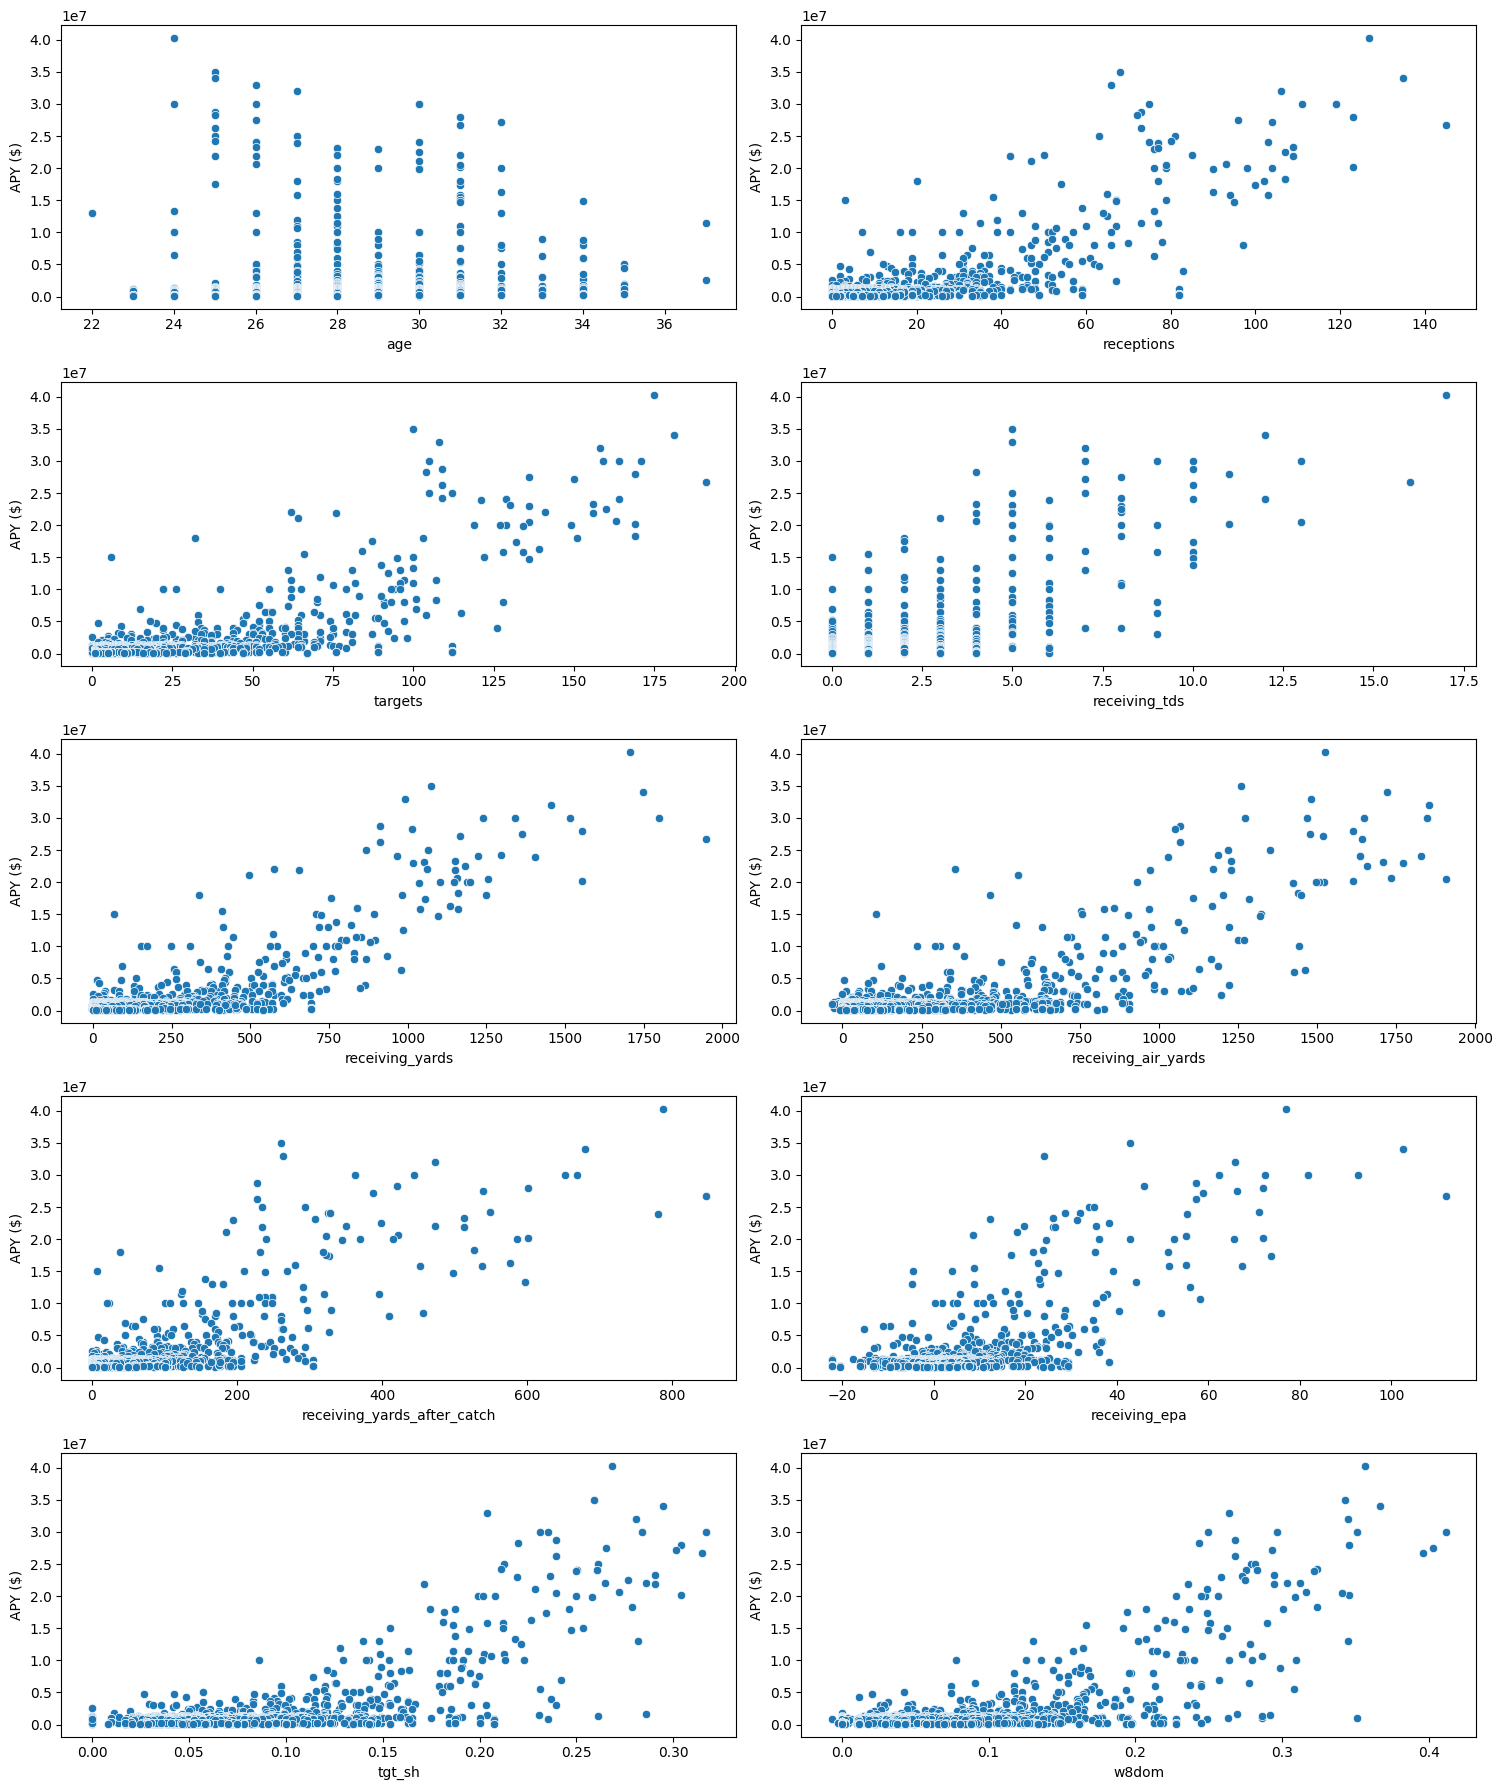

In [22]:
# Let's take a look at some of the features that we have to get an idea of some of the patterns
feat_scatterplots, feat_axes = plt.subplots(5, 2, figsize=(15, 18)) #Subplot with 5 rows and 2 columns

feat_axes = feat_axes.flatten() # Flatten so we can access the axes easier

for i, feature in enumerate(rel_features):
    sns.scatterplot(x = combined_stats[feature], y = combined_stats['APY ($)'], ax = feat_axes[i])

feat_scatterplots.tight_layout()
feat_scatterplots.show()
feat_scatterplots.savefig('../img/nfl_feat_scatter.png')

In [23]:
from sklearn.base import BaseEstimator
from typing import Callable

def evaluate_model(model: BaseEstimator, X_trn: np.ndarray, X_tst: np.ndarray, y_trn: np.ndarray, y_tst: np.ndarray, metrics: list[Callable[[np.ndarray, np.ndarray], float]], model_name: str = 'model', verbose: bool = True) -> tuple[dict[str, float], np.ndarray, np.ndarray]:
    """Calculate the metric scores for a model

    Args:
        model (BaseEstimator): scikit learn model to use for evaluation
        X_trn (np.ndarray): training input for the model
        X_tst (np.ndarray): testing input 
        y_trn (np.ndarray): training output
        y_tst (np.ndarray): testing output
        metrics (list[Callable[[np.ndarray, np.ndarray], float]]): metrics to evaluate the model on; from sklearn.metrics
        model_name (str, optional): name of the model to use in print statements. Defaults to 'model'.

    Returns:
        tuple[dict[str, float], np.ndarray, np.ndarray]: metrics of the model, train predictions of model, and test predictions
    """
    metric_scores: dict[str, float] = {}
    
    # Calculate the training metrics
    train_preds: np.ndarray = model.predict(X_trn)
    for metric in metrics:
        metric_name: str = metric.__name__.replace('_', ' ').title()
        metric_score: float = metric(y_true = y_trn, y_pred = train_preds)
        metric_scores[f'{metric_name}_train'] = metric_score
        if verbose:
            print(f'The {metric_name} on the training data of our {model_name} is {metric_score:,.4f}')
    
    # Calculate the test metrics
    test_preds: np.ndarray = model.predict(X_tst)
    for metric in metrics:
        metric_name: str = metric.__name__.replace('_', ' ').title()
        metric_score: float = metric(y_true = y_tst, y_pred = test_preds)
        metric_scores[f'{metric_name}_test'] = metric_score
        if verbose:
            print(f'The {metric_name} on the testing data of our {model_name} is {metric_score:,.4f}')

    return metric_scores, train_preds, test_preds

In [24]:
def make_plot(X_tst: np.ndarray, y_true: np.ndarray, y_preds: np.ndarray, title: str) -> plt:
    """Make a plot comparing test data to the predictions by a model

    Args:
        X_tst (np.ndarray): test data used to evaluate the model
        y_true (np.ndarray): true labels of test data
        y_preds (np.ndarray): labels predicted on the test data by the model
        title (str): title of plot

    Returns:
        plt: scatterplot with the inputted data
    """
    data: pd.DataFrame = pd.DataFrame({
        'Receiving Yards': X_tst.flatten(),  
        'APY': y_true.flatten()
    })
    plot = sns.scatterplot(data = data, x = 'Receiving Yards', y = 'APY', size = 'APY', legend = False)
    plot.plot(X_tst, y_preds, color='red', label='Regression line')
    plot.set_title(title)

    return plot

The Root Mean Squared Error on the training data of our Basic Linear Regression Model is 2,983,494.0606
The R2 Score on the training data of our Basic Linear Regression Model is 0.6813
The Root Mean Squared Error on the testing data of our Basic Linear Regression Model is 2,798,006.3796
The R2 Score on the testing data of our Basic Linear Regression Model is 0.4157


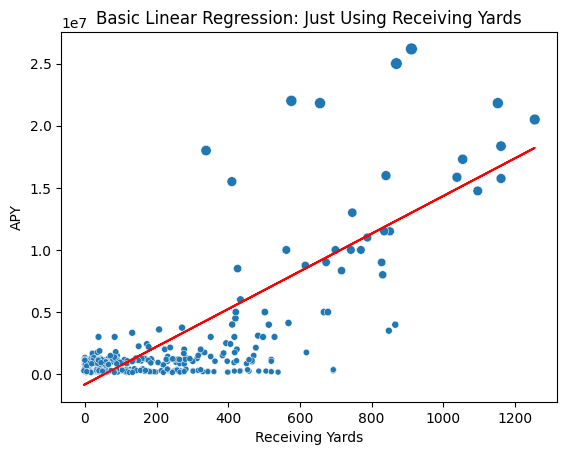

In [25]:
basic_X_trn: np.ndarray
basic_X_tst: np.ndarray
basic_y_trn: np.ndarray 
basic_y_tst: np.ndarray 

# We have to use reshape here to turn our row vectors into column vectors
basic_X_trn, basic_X_tst, basic_y_trn, basic_y_tst = train_test_split(combined_stats['receiving_yards'].values.reshape(-1, 1), combined_stats['APY ($)'].values.reshape(-1, 1), test_size = .33, random_state = 42)

# Initialize our basic Linear Regression model and train it on the data
basic_model: LinearRegression = LinearRegression()
basic_model.fit(basic_X_trn, basic_y_trn)

# Evaluate our model
basic_eval: dict 
basic_train_preds: np.ndarray
basic_test_preds: np.ndarray

basic_eval, basic_train_preds, basic_test_preds = evaluate_model(model = basic_model, X_trn = basic_X_trn, X_tst = basic_X_tst, y_trn = basic_y_trn, y_tst = basic_y_tst, metrics = [root_mean_squared_error, r2_score], model_name = 'Basic Linear Regression Model')

# Plotting code
basic_plot = make_plot(basic_X_tst, basic_y_tst, basic_test_preds, "Basic Linear Regression: Just Using Receiving Yards")
plt.show()

# III. Experiment II: Using a Better Model and Features

In [26]:
# Let's create a new training set that relies on a few more features
X_trn: np.ndarray
X_tst: np.ndarray
y_trn: np.ndarray 
y_tst: np.ndarray 

# Some receivers just play special teams and don't necessarily really play as a traditional Wide Receiver, so if there w8dom value is NaN here, we can assume they fall into that category
X_trn, X_tst, y_trn, y_tst = train_test_split(combined_stats[rel_features].dropna(axis = 0, how = 'any', subset = 'w8dom').values, combined_stats.dropna(axis = 0, how = 'any', subset = 'w8dom')['APY ($)'].values.reshape(-1, 1), test_size = .33, random_state = 42)

In [27]:
# Testing out a Decision Tree
tree_model: DecisionTreeRegressor = DecisionTreeRegressor()
tree_model.fit(X_trn, y_trn)

tree_eval: dict
tree_train_preds: np.ndarray
tree_test_preds: np.ndarray

tree_eval, tree_train_preds, tree_test_preds = evaluate_model(model = tree_model, X_trn = X_trn, X_tst = X_tst, y_trn = y_trn, y_tst = y_tst, metrics = [root_mean_squared_error, r2_score], model_name = 'Decision Tree Regression Model')

The Root Mean Squared Error on the training data of our Decision Tree Regression Model is 291,430.6363
The R2 Score on the training data of our Decision Tree Regression Model is 0.9970
The Root Mean Squared Error on the testing data of our Decision Tree Regression Model is 2,288,790.0169
The R2 Score on the testing data of our Decision Tree Regression Model is 0.6443


In [28]:
# What feature is our model overfitting to?
pd.Series(tree_model.feature_importances_, combined_stats[rel_features].columns).sort_values(ascending = False)

receiving_yards                0.806376
tgt_sh                         0.060913
targets                        0.038668
w8dom                          0.029500
receiving_epa                  0.017403
receiving_air_yards            0.016052
age                            0.013541
receptions                     0.007803
receiving_yards_after_catch    0.005176
receiving_tds                  0.004569
dtype: float64

In [29]:
# Let's see if we can remove receiving_yards to get similar accuracy
rel_features.remove('receiving_yards')
X_trn, X_tst, y_trn, y_tst = train_test_split(combined_stats[rel_features].dropna(axis = 0, how = 'any', subset = 'w8dom').values, combined_stats.dropna(axis = 0, how = 'any', subset = 'w8dom')['APY ($)'].values.reshape(-1, 1), test_size = .33, random_state = 42)
tree_model.fit(X_trn, y_trn)
tree_eval, tree_train_preds, tree_test_preds = evaluate_model(model = tree_model, X_trn = X_trn, X_tst = X_tst, y_trn = y_trn, y_tst = y_tst, metrics = [root_mean_squared_error, r2_score], model_name = 'Decision Tree Regression Model')

The Root Mean Squared Error on the training data of our Decision Tree Regression Model is 291,430.6363
The R2 Score on the training data of our Decision Tree Regression Model is 0.9970
The Root Mean Squared Error on the testing data of our Decision Tree Regression Model is 2,176,075.7494
The R2 Score on the testing data of our Decision Tree Regression Model is 0.6785


In [30]:
# View new feature importances
pd.Series(tree_model.feature_importances_, combined_stats[rel_features].columns).sort_values(ascending = False)

tgt_sh                         0.696595
targets                        0.114698
w8dom                          0.055644
receiving_air_yards            0.052225
receiving_epa                  0.035021
age                            0.016034
receiving_yards_after_catch    0.012006
receiving_tds                  0.009475
receptions                     0.008303
dtype: float64

In [31]:
# Let's try to over-combat the overfitting with an ensemble model
rf: RandomForestRegressor = RandomForestRegressor()
rf.fit(X_trn, y_trn.ravel())

rf_eval: dict 
rf_train_preds: np.ndarray
rf_test_preds: np.ndarray

rf_eval, rf_train_preds, rf_test_preds = evaluate_model(model = rf, X_trn = X_trn, X_tst = X_tst, y_trn = y_trn, y_tst = y_tst, metrics = [root_mean_squared_error, r2_score], model_name = 'Random Forest Regression Model')

The Root Mean Squared Error on the training data of our Random Forest Regression Model is 797,022.3446
The R2 Score on the training data of our Random Forest Regression Model is 0.9779
The Root Mean Squared Error on the testing data of our Random Forest Regression Model is 1,852,110.1425
The R2 Score on the testing data of our Random Forest Regression Model is 0.7671


In [32]:
pd.Series(rf.feature_importances_, combined_stats[rel_features].columns).sort_values(ascending = False)

tgt_sh                         0.385418
receiving_air_yards            0.301290
w8dom                          0.064857
targets                        0.062970
receiving_yards_after_catch    0.055652
receiving_epa                  0.051901
receptions                     0.051064
age                            0.015059
receiving_tds                  0.011789
dtype: float64

In [33]:
# Another ensemble method, but maybe even more generalizable and powerful: XGBoost!
xgboost: XGBRegressor = XGBRegressor()
xgboost.fit(X_trn, y_trn)


xgboost_eval: dict 
xgboost_train_preds: np.ndarray
xgboost_test_preds: np.ndarray

xgboost_eval, xgboost_train_preds, xgboost_test_preds = evaluate_model(model = xgboost, X_trn = X_trn, X_tst = X_tst, y_trn = y_trn, y_tst = y_tst, metrics = [root_mean_squared_error, r2_score], model_name = 'XGBoost Regression Model')

The Root Mean Squared Error on the training data of our XGBoost Regression Model is 293,540.1383
The R2 Score on the training data of our XGBoost Regression Model is 0.9970
The Root Mean Squared Error on the testing data of our XGBoost Regression Model is 1,902,217.4789
The R2 Score on the testing data of our XGBoost Regression Model is 0.7543


# IV. Experiment III: Hyperparameter Tuning

In [50]:
# Hyperparameter Tuning for Decision Trees
from typing import Union

tree_param_grid: dict[str, list[Union[str, int]]] = {
    "criterion": ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    "splitter": ['best', 'random'],
    "max_depth": [6,7,8,9,10,11,12],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

tree_random_search: RandomizedSearchCV = RandomizedSearchCV(
    estimator = DecisionTreeRegressor(random_state=42),
    param_distributions = tree_param_grid,
    cv = 5,
    scoring = ["neg_root_mean_squared_error", "r2"],
    refit = "neg_root_mean_squared_error",
    verbose = 1,
    n_iter = 11
)

tree_random_search.fit(X_trn, y_trn)
tuned_tree: DecisionTreeRegressor = tree_random_search.best_estimator_
print(f'The best estimator parameters were: {tree_random_search.best_params_}')

tuned_tree_eval, tuned_tree_train_preds, tuned_tree_test_preds = evaluate_model(model = tuned_tree, X_trn = X_trn, X_tst = X_tst, y_trn = y_trn, y_tst = y_tst, metrics = [root_mean_squared_error, r2_score], model_name = 'Tuned Decision Tree Regression Model')

Fitting 5 folds for each of 11 candidates, totalling 55 fits
The best estimator parameters were: {'splitter': 'random', 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'squared_error'}
The Root Mean Squared Error on the training data of our Tuned Decision Tree Regression Model is 1,624,393.3960
The R2 Score on the training data of our Tuned Decision Tree Regression Model is 0.9083
The Root Mean Squared Error on the testing data of our Tuned Decision Tree Regression Model is 2,122,128.5476
The R2 Score on the testing data of our Tuned Decision Tree Regression Model is 0.6943


In [35]:
# Hyperparameter tuning for Random Forest
rf_param_grid: dict[str, list[Union[str, int]]] = {
    'n_estimators': [100, 150, 200],
    "criterion": ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': [7,8,9,10,11, None],
    'bootstrap': [True, False],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf_random_search: RandomizedSearchCV = RandomizedSearchCV(
    estimator = RandomForestRegressor(random_state=42),
    param_distributions = rf_param_grid,
    cv = 5,
    scoring = ["neg_root_mean_squared_error", "r2"],
    refit = "neg_root_mean_squared_error",
    verbose = 1,
    n_iter = 11
)

rf_random_search.fit(X_trn, y_trn.ravel())
tuned_forest: RandomForestRegressor = rf_random_search.best_estimator_
print(f'The best estimator parameters were: {rf_random_search.best_params_}')

tuned_forest_eval, tuned_forest_train_preds, tuned_forest_test_preds = evaluate_model(model = tuned_forest, X_trn = X_trn, X_tst = X_tst, y_trn = y_trn, y_tst = y_tst, metrics = [root_mean_squared_error, r2_score], model_name = 'Tuned Random Forest Regression Model')

Fitting 5 folds for each of 11 candidates, totalling 55 fits
The best estimator parameters were: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'absolute_error', 'bootstrap': True}
The Root Mean Squared Error on the training data of our Tuned Random Forest Regression Model is 854,321.2662
The R2 Score on the training data of our Tuned Random Forest Regression Model is 0.9746
The Root Mean Squared Error on the testing data of our Tuned Random Forest Regression Model is 1,817,997.5816
The R2 Score on the testing data of our Tuned Random Forest Regression Model is 0.7756


In [36]:
xgboost_param_grid: dict[str, list[Union[str, int]]] = {
    "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
    "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight" : [1, 3, 5, 7 ],
    "gamma": [0.0,0.1,0.2 ,0.3,0.4 ],
    "colsample_bytree" : [0.3,0.4,0.5 ,0.7 ]
}

xgboost_random_search: RandomizedSearchCV = RandomizedSearchCV(
    estimator = XGBRegressor(random_state=42),
    param_distributions = xgboost_param_grid,
    cv = 5,
    scoring = ["neg_root_mean_squared_error", "r2"],
    refit = "neg_root_mean_squared_error",
    verbose = 1,
    n_iter = 11
)

xgboost_random_search.fit(X_trn, y_trn.ravel())
tuned_xgboost: XGBRegressor = xgboost_random_search.best_estimator_
print(f'The best estimator parameters were: {xgboost_random_search.best_params_}')

tuned_xgboost_eval, tuned_xgboost_train_preds, tuned_xgboost_test_preds = evaluate_model(model = tuned_xgboost, X_trn = X_trn, X_tst = X_tst, y_trn = y_trn, y_tst = y_tst, metrics = [root_mean_squared_error, r2_score], model_name = 'Tuned XGBoost Regression Model')

Fitting 5 folds for each of 11 candidates, totalling 55 fits
The best estimator parameters were: {'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.4}
The Root Mean Squared Error on the training data of our Tuned XGBoost Regression Model is 644,251.0332
The R2 Score on the training data of our Tuned XGBoost Regression Model is 0.9856
The Root Mean Squared Error on the testing data of our Tuned XGBoost Regression Model is 1,765,583.5697
The R2 Score on the testing data of our Tuned XGBoost Regression Model is 0.7884


In [52]:
results: dict[list[float]] = {
    "model": ['Decision Tree', 'Random Forest', 'XGBoost'],
    "base_train_rmse": [
        tree_eval['Root Mean Squared Error_train'],
        rf_eval['Root Mean Squared Error_train'],
        xgboost_eval['Root Mean Squared Error_train'],
    ],
    "base_train_r2": [
        tree_eval['R2 Score_train'],
        rf_eval['R2 Score_train'],
        xgboost_eval['R2 Score_train'],
    ],
    "base_test_rmse": [
        tree_eval['Root Mean Squared Error_test'],
        rf_eval['Root Mean Squared Error_test'],
        xgboost_eval['Root Mean Squared Error_test'],
    ],
    "base_test_r2": [
        tree_eval['R2 Score_test'],
        rf_eval['R2 Score_test'],
        xgboost_eval['R2 Score_test'],
    ],
    "hyperparameter_train_rmse": [
        tuned_tree_eval['Root Mean Squared Error_train'],
        tuned_forest_eval['Root Mean Squared Error_train'],
        tuned_xgboost_eval['Root Mean Squared Error_train'],
    ],
    "hyperparameter_train_r2": [
        tuned_tree_eval['R2 Score_train'],
        tuned_forest_eval['R2 Score_train'],
        tuned_xgboost_eval['R2 Score_train'],
    ],
    "hyperparameter_test_rmse": [
        tuned_tree_eval['Root Mean Squared Error_test'],
        tuned_forest_eval['Root Mean Squared Error_test'],
        tuned_xgboost_eval['Root Mean Squared Error_test'],
    ],
    "hyperparameter_test_r2": [
        tuned_tree_eval['R2 Score_test'],
        tuned_forest_eval['R2 Score_test'],
        tuned_xgboost_eval['R2 Score_test'],
    ]
}

results_df: pd.DataFrame = pd.DataFrame(results)

results_df

,model,base_train_rmse,base_train_r2,base_test_rmse,base_test_r2,hyperparameter_train_rmse,hyperparameter_train_r2,hyperparameter_test_rmse,hyperparameter_test_r2
0,Decision Tree,291430.636334,0.997047,2.176076e+06,0.678510,1.624393e+06,0.908269,2.122129e+06,0.694253
1,Random Forest,797022.344564,0.977916,1.852110e+06,0.767109,8.543213e+05,0.974627,1.817998e+06,0.775609
2,XGBoost,293540.138347,0.997005,1.902217e+06,0.754337,6.442510e+05,0.985571,1.765584e+06,0.788361


In [60]:
results_table = (
    GT(results_df)
    .tab_header(
        title = md('**Summary of Model Performance on NFL Wide Receiver Contracts**')
    )
    .fmt_currency(
        columns=[col for col in results_df.columns if "rmse" in col],
        decimals=2
    )
    .fmt_number(
        columns=[col for col in results_df.columns if "r2" in col],
        decimals=2
    )
    .tab_spanner(
        label = md('**Training Data**'),
        columns = ['base_train_rmse', 'base_train_r2'],
    )
    .tab_spanner(
        label = md('**Testing Data**'),
        columns = ['base_test_rmse', 'base_test_r2'],
    )
    .tab_spanner(
        label = md('**Training Data** '),
        columns = ['hyperparameter_train_rmse', 'hyperparameter_train_r2'],
    )
    .tab_spanner(
        label = md('**Testing Data** '),
        columns = ['hyperparameter_test_rmse', 'hyperparameter_test_r2'],
    )
    .tab_spanner(
        label = md('**Base Model**'),
        columns = ['base_train_rmse', 'base_train_r2', 'base_test_rmse', 'base_test_r2']
    )
    .tab_spanner(
        label = md('**Hyperparameter Tuned Models**'),
        columns = ['hyperparameter_train_rmse', 'hyperparameter_train_r2', 'hyperparameter_test_rmse', 'hyperparameter_test_r2']
    )
    .cols_label(
        model = 'Model Name',
        base_train_rmse = 'RMSE',
        base_train_r2 = 'R2 Score',
        base_test_rmse = 'RMSE',
        base_test_r2 = 'R2 Score',
        hyperparameter_train_rmse = 'RMSE',
        hyperparameter_train_r2 = 'R2 Score',
        hyperparameter_test_rmse = 'RMSE',
        hyperparameter_test_r2 = 'R2 Score'
    )
    .tab_options(
        table_font_names=system_fonts("industrial")
    )
    .data_color(
        columns = ['base_train_r2', 'base_test_r2', 'hyperparameter_train_r2', 'hyperparameter_test_r2'],
        palette = 'RdPu',
    )
    .data_color(
        columns = ['base_train_rmse', 'base_test_rmse', 'hyperparameter_train_rmse', 'hyperparameter_test_rmse'],
        palette = 'BuPu',
        reverse = True
    )
)

# results_table.show()

results_table.save(file='../img/nfl_results_table.png', scale = 17)

GT(_tbl_data=           model  base_train_rmse  base_train_r2  base_test_rmse  \
0  Decision Tree    291430.636334       0.997047    2.176076e+06   
1  Random Forest    797022.344564       0.977916    1.852110e+06   
2        XGBoost    293540.138347       0.997005    1.902217e+06   

   base_test_r2  hyperparameter_train_rmse  hyperparameter_train_r2  \
0      0.678510               1.624393e+06                 0.908269   
1      0.767109               8.543213e+05                 0.974627   
2      0.754337               6.442510e+05                 0.985571   

   hyperparameter_test_rmse  hyperparameter_test_r2  
0              2.122129e+06                0.694253  
1              1.817998e+06                0.775609  
2              1.765584e+06                0.788361  , _body=<great_tables._gt_data.Body object at 0x0000022BE8F1EAD0>, _boxhead=Boxhead([ColInfo(var='model', type=<ColInfoTypeEnum.default: 1>, column_label='Model Name', column_align='left', column_width=None), ColInfo(var='base_train_rmse', type=<ColInfoTypeEnum.default: 1>, column_label='RMSE', column_align='right', column_width=None), ColInfo(var='base_train_r2', type=<ColInfoTypeEnum.default: 1>, column_label='R2 Score', column_align='right', column_width=None), ColInfo(var='base_test_rmse', type=<ColInfoTypeEnum.default: 1>, column_label='RMSE', column_align='right', column_width=None), ColInfo(var='base_test_r2', type=<ColInfoTypeEnum.default: 1>, column_label='R2 Score', column_align='right', column_width=None), ColInfo(var='hyperparameter_train_rmse', type=<ColInfoTypeEnum.default: 1>, column_label='RMSE', column_align='right', column_width=None), ColInfo(var='hyperparameter_train_r2', type=<ColInfoTypeEnum.default: 1>, column_label='R2 Score', column_align='right', column_width=None), ColInfo(var='hyperparameter_test_rmse', type=<ColInfoTypeEnum.default: 1>, column_label='RMSE', column_align='right', column_width=None), ColInfo(var='hyperparameter_test_r2', type=<ColInfoTypeEnum.default: 1>, column_label='R2 Score', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000022BE8F78E90>, _spanners=Spanners([SpannerInfo(spanner_id='**Training Data**', spanner_level=0, spanner_label=Md(text='**Training Data**'), spanner_units=None, spanner_pattern=None, vars=['base_train_rmse', 'base_train_r2'], built=None), SpannerInfo(spanner_id='**Testing Data**', spanner_level=0, spanner_label=Md(text='**Testing Data**'), spanner_units=None, spanner_pattern=None, vars=['base_test_rmse', 'base_test_r2'], built=None), SpannerInfo(spanner_id='**Training Data** ', spanner_level=0, spanner_label=Md(text='**Training Data** '), spanner_units=None, spanner_pattern=None, vars=['hyperparameter_train_rmse', 'hyperparameter_train_r2'], built=None), SpannerInfo(spanner_id='**Testing Data** ', spanner_level=0, spanner_label=Md(text='**Testing Data** '), spanner_units=None, spanner_pattern=None, vars=['hyperparameter_test_rmse', 'hyperparameter_test_r2'], built=None), SpannerInfo(spanner_id='**Base Model**', spanner_level=1, spanner_label=Md(text='**Base Model**'), spanner_units=None, spanner_pattern=None, vars=['base_train_rmse', 'base_train_r2', 'base_test_rmse', 'base_test_r2'], built=None), SpannerInfo(spanner_id='**Hyperparameter Tuned Models**', spanner_level=1, spanner_label=Md(text='**Hyperparameter Tuned Models**'), spanner_units=None, spanner_pattern=None, vars=['hyperparameter_train_rmse', 'hyperparameter_train_r2', 'hyperparameter_test_rmse', 'hyperparameter_test_r2'], built=None)]), _heading=Heading(title=Md(text='**Summary of Model Performance on NFL Wide Receiver Contracts**'), subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='base_train_r2', rows=[0]), grpname=None, colname='base_train_r2', rownum=0, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, tr

![Results Table](../img/nfl_results_table.png?12)

In [41]:
print(f"{((rf.predict(combined_stats.loc[combined_stats['Name'] == 'Stefon Diggs'][rel_features].iloc[1].values.reshape(1,-1))[0] + rf.predict(combined_stats.loc[combined_stats['Name'] == 'Stefon Diggs'][rel_features].iloc[0].values.reshape(1,-1))[0]) / 2):,}")

19,002,016.39


In [42]:
print(f"{(rf.predict(combined_stats.loc[combined_stats['Name'] == 'Chris Godwin'][rel_features].iloc[0].values.reshape(1,-1))[0]):,}")

12,028,656.43


In [43]:
print(f"{(rf.predict((rel_nfl_data.loc[(rel_nfl_data['player_name'] == 'Chris Godwin') & (rel_nfl_data['season'] == 2023)][rel_features].iloc[0].values.reshape(1,-1))))[0]:,}")

18,610,990.2


In [44]:
rel_nfl_data.loc[(rel_nfl_data['player_name'] == 'Chris Godwin') & (rel_nfl_data['season'] == 2023)][rel_features].iloc[0].values.reshape(1,-1)[0]

array([2.80000000e+01, 8.30000000e+01, 1.30000000e+02, 2.00000000e+00,
       1.18000000e+03, 3.76000000e+02, 4.40019126e+01, 2.28873239e-01,
       2.16857425e-01])

In [45]:
combined_stats.loc[combined_stats['Name'] == 'Chris Godwin'].iloc[0]

Name                            Chris Godwin
Team                              Buccaneers
Position                       Wide Receiver
Sign Date                               2025
Contract Length                            3
Contract Value ($)                66000000.0
APY ($)                           22000000.0
Guarantees ($)                    44000000.0
Active                                     1
age                                     28.0
season                                  2024
height                                  73.0
receptions                                50
targets                                   62
receiving_yards                        576.0
receiving_tds                              5
receiving_air_yards                    356.0
receiving_yards_after_catch            350.0
receiving_epa                      35.511458
racr                               12.045786
tgt_sh                              0.264957
ay_sh                               0.246196
yac_sh    